In [370]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import csv
import re
import string
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D



In [84]:

def transformDataframe(frame):
    
    frame['texture'] = frame.apply (lambda row: row.imagename.split('_')[6].split('.')[0].split('-')[1].rstrip(string.digits), axis=1)
    frame['correct_t'] = frame.apply(lambda row:  1 if row.object_response == row.texture else 0, axis=1)
    frame['correct_s'] =  frame.apply(lambda row:  1 if row.object_response == row.category else 0, axis=1)
    frame['correct'] = frame.apply(lambda row:  1 if row.correct_t == 1 or row.correct_s == 1 else 0, axis=1)
    frame['total'] = frame.apply(lambda row:  1, axis=1)

    return frame[['texture', 'category','correct_t', 'correct_s', 'correct', 'total']]

In [383]:
directory = "../raw-data/style-transfer-512-nomask-experiment/"
datafiles = [f for f in listdir(directory) if isfile(join(directory, f)) and f.endswith('.csv') and 'subject' not in f]
scatterdata = {}
modelname = re.compile('experiment_(.*)_session')
for file in datafiles:
    name = modelname.findall(file)[0]
    if name:
        filedata = pd.read_csv(directory+file)
        filedata = transformDataframe(filedata)
        summed_filedata = filedata.groupby(['category']).sum()
        summed_filedata['correct_fraction'] = summed_filedata['correct'] / summed_filedata['total']
        
        only_cue = filedata[filedata.texture != filedata.category]
        summed_only_cue = only_cue.groupby(['category']).sum()
        summed_only_cue['shape_fraction'] = summed_only_cue['correct_s'] / summed_only_cue['correct']
        summed_only_cue['texture_fraction'] = summed_only_cue['correct_t'] / summed_only_cue['correct']
        scatterdata[name] = pd.concat([summed_only_cue[['shape_fraction', 'correct_s', 'correct']], summed_filedata[['correct_fraction']]], axis=1)
        

    
barplotdata= {}
for name in data:
    for row in data[name].itertuples():
        if row.Index not in barplotdata:
            barplotdata[row.Index] = {}
        barplotdata[row.Index][name] = row.correct_fraction

       
        

0.4294385432473445
0.3119015047879617
0.17218543046357615


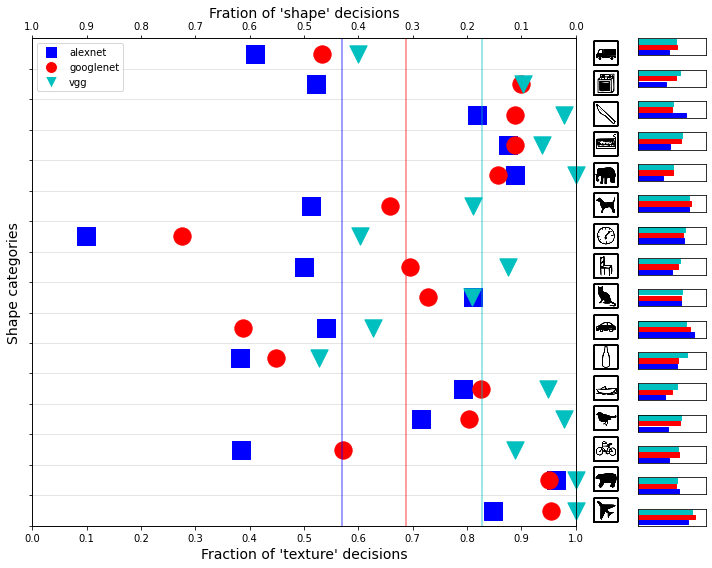

In [384]:
fig = plt.figure(figsize=(10,8))
spec2 = fig.add_gridspec(16, 16)
main = fig.add_subplot(spec2[:, 0:13])

xticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
main.set_xticks(xticks)
main.set_ylim(0, 16)
main.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
main.set_yticklabels([])
main.yaxis.grid(True, alpha=0.4)
main.set_xlabel("Fraction of 'texture' decisions", fontsize=14)
main.set_ylabel('Shape categories', fontsize=14)

shapeAxis = main.twiny()
shapeAxis.set_xticks(xticks)
shapeAxis.set_xlim(0, 1)
shapeAxis.invert_xaxis()
shapeAxis.set_xlabel("Fration of 'shape' decisions", fontsize=14)

for i, label in enumerate(scatterdata[next(iter(scatterdata))].index.values):
        img = plt.imread(f'../data-analysis/category-images/{label}.png')
        im = OffsetImage(img, zoom=0.20)
        im.image.axes = main
        ab = AnnotationBbox(im, (1, i), xybox=(30, 16), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
        main.add_artist(ab)

colors = ['b', 'r', 'c', 'm']
markers = ['s', 'o', 'v', 'D']

legend_elements = []
for i, item in enumerate(scatterdata):
    x_avg = scatterdata[item].correct_s.mean() / scatterdata[item].correct.mean()
    plt.plot([x_avg, x_avg], [0, 16], c=colors[i], alpha=0.5)
    scatter = plt.scatter(scatterdata[item].shape_fraction.values, np.arange(0, 16) + 0.5, s=300, c=colors[i],  marker=markers[i])
    scatter.set_clip_on(False)
    legend_elements.append(Line2D([0], [0], color='w', markerfacecolor=colors[i], markersize=12, marker=markers[i], label=item))
   
    
    
    
for i, category in enumerate(scatterdata[item].index.values):
    barfig = fig.add_subplot(spec2[i, 14:16])
    barfig.set_xlim(0, 1)
    barfig.xaxis.set_visible(False)
    barfig.yaxis.set_visible(False)
    y_pos = np.arange(len(barplotdata[category]))
    barplot = barfig.barh(y_pos, barplotdata[category].values(), align='center')
    for j in y_pos:
        barplot[j].set_color(colors[j])

main.legend(handles=legend_elements, loc='upper left')
plt.tight_layout()
plt.margins(0.1)
plt.show()



